# Relative Value Modeling of the Yield Curve

## Introduction
In this notebook we build a **Relative Value Model** of the US Treasury yield curve.

In a relative value model we are interested in determining if particular tenors (maturities) on the curve seem out of place relative to other data points. We will focus on prediction of the 30 Yield treasury yield assuming that the other points on the yield curve are known.

We will show that the prediction of the *level* of the 30 year rate is challenging because observations are not statistically independent. 

However, we can predict the  day to day change of the 30  year yield based on the changes of other points of the curve with high accuracy (94% out of sample $R^2$).

### Road Map

In this notebook we will 
1. Define the G2++ Two Factor Gaussian interest rate model
2. We will use G2++ model to fit the US treasury yield Curve at one fixed date.
3. Train model hyper-parameters to predit the yield of the 30 year treasury yield, and analyze the results.
4. Train model to predict 30Y us treasury yield changes and analyze results.

We will see that due to the high correlation between rate curves at different dates, results on yield levels are not good. Yield changes, however can still be predicted with good out of sample performance.

### US Treasury Yield Curve

The yield of a bond is a measure of the compounded rate of return earned by investing in that bond until maturity.

A  bond price is inversely correlated with its yield, so that investors like to buy bonds with high yields (low prices), but would prefer yields to come down once invested.

Bonds with longer maturities usually have higher yields to compensate investors for tying their investment funds for a longer period of type.

A plot of bond yield versus bond maturity is called a  ** yield curve** and it is a representation of the trade-off between the liquidity (how many years money is invested) and rate of return.

The US Treasury department is responsible for financing the expending needs of the US government. It has borrowed
$ 14 trillion dollars in the  financial markets by issuing bonds of multiple maturities.

Given the size and liquidity of the market for us government debt the analysis  of the ** us treasury yield curve** is of great interest for economist studying the us economy or financial participants looking to invest large sums of money.


A realistic yield curve model will be dealing with hundreds of different points (treasury bonds) on the curve
<img src="images/treasury_curve.gif">
Figure provided by the [Federal Reserve](https://www.federalreserve.gov/pubs/feds/2006/200628/index.html), where they fit the yield curve to a 6 parameter model.

We will, however, deal only with a simplified view based on the H15 constant maturity treasury points
<img src="images/H15_curve.jpg"> 

We will fit those points to a specific functional form called the `G2++` rate curve model.

### Preliminaries

#### Imports

In [1]:
from datetime import date

import numpy as np
import pandas as pd
import scipy.optimize

import statsmodels.graphics.tsaplots

import matplotlib.pyplot as plt
%matplotlib inline

/home/manel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Data

In [2]:
data_dir="../../data/finance"

In [3]:
H15=pd.read_csv(data_dir+"/H15.csv",index_col=[0],parse_dates=[0])
H15.head()

,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
DATE,,,,,,,,,,
2006-02-09,4.52,4.67,4.66,4.66,4.62,4.55,4.55,4.54,4.72,4.51
2006-02-10,4.53,4.70,4.70,4.69,4.67,4.59,4.59,4.59,4.76,4.55
2006-02-13,4.55,4.71,4.70,4.68,4.66,4.58,4.58,4.58,4.76,4.56
2006-02-14,4.55,4.72,4.71,4.69,4.68,4.61,4.61,4.62,4.80,4.60
2006-02-15,4.55,4.70,4.70,4.71,4.68,4.60,4.60,4.61,4.78,4.58


In [4]:
tenors=np.array([3.0/12,6.0/12,1,2,3,5,7,10,20,30])

## The G2++ Gaussian, 2 Factor Model


    
The G2++ Model is a close derivative of the Two Factor Hull White Model
(See for example [Martin Bohner notes](https://web.mst.edu/~bohner/fim-10/fim-chap6.pdf)), but the G2++ formulation is analytically more convenient. 

It is commonly used to price path dependent interest rate derivatives because it provides a realistic, yet simple, description of the dynamic of the yield curve.


For a more thorough discussion of Interest rate models, see [Martin Bohner's complete course](https://web.mst.edu/~bohner/fim-10/)



The derivation for the bond prices for the G2++ model can be found in [Martin Bohner notes](https://web.mst.edu/~bohner/fim-10/fim-chap6.pdf), or on the following 
[paper](https://www.math.kth.se/matstat/seminarier/reports/M-exjobb12/120220b.pdf).


The Gaussian G2++ model is defined by a short rate given by
$$
    r(t) = r_1(t) + r_2(t) + \varphi(t),
$$
where
\begin{align}
    \textrm{d}r_1(t) &= - \lambda_1 r_1 \textrm{d} t + \sigma_1 \textrm{d}W_1,\,\,\,\,x_1(0)=0\\
    \textrm{d}r_2(t) &= - \lambda_2 r_2 \textrm{d} t + \sigma_2 \textrm{d}W_2,\,\,\,\,x_2(0)=0\\
    \mathbb{E}(\textrm{d}W_1 \textrm{d}W_2) &= \rho \textrm{d} t \text{ with } -1\le \rho \le 1
\end{align}
with $k_1,k_2,\sigma_1,\sigma_2 > 0$ and $W_1$, $W_2$ standard Brownian motions.

It can be shown (see Theorem 6.4) on [Martin Bohner notes](https://web.mst.edu/~bohner/fim-10/fim-chap6.pdf) The price of a zero coupon bond, at time t, for tenor (bond expiry) T is given by
$$
    P(t,T) = e^{ -\int \textrm{d}\tau\, \varphi(\tau) - D_1(t,T)r_1 - D_2(t,T)r_2 + \frac{1}{2} V(t,T)}
$$
where
\begin{align}
   D_1(t,T) &= \frac{1-e^{-k_1(T-t)}}{k_1} \\
   D_2(t,T) &= \frac{1-e^{-k_2(T-t)}}{k_2} \\
   V^2(t,T) &= \frac{\sigma^2_1}{k^2_1}\left( T-t  +\frac{2}\lambda_1 e^{-\lambda_1 (T-t)}-\frac{1}{2}e^{-2\lambda_1(T-t)} - \frac{3}{2\lambda_1}  \right) \\
            &+   \frac{\sigma^2_2}{k^2_2}\left( T-t  +\frac{2}\lambda_2 e^{-\lambda_2 (T-t)}-\frac{1}{2}e^{-2\lambda_2(T-t)} - \frac{3}{2\lambda_2}  \right) \\
            &+2\rho\frac{\sigma_1\sigma_2}{k_1 k_2}\left(T-t +\frac{1}\lambda_1 e^{-\lambda_1 (T-t)}++\frac{1}\lambda_2 e^{-\lambda_2 (T-t)} - \frac{e^{(\lambda_1+\lambda_2)(T-t)} -1}{\lambda_1+\lambda_2}\right)
\end{align}

In derivative pricing applications one usually fits the function $\varphi(t)$ so that at the pricing date $t=0$
bond prices $P(0,T)$ matche the market for all possible tenors  $T$ (the no-arbitrage condition). 

For **relative value** applications, however, where we want to use the model to make a prediction on unobserved tenors $T$, we simply set $\varphi$ to a constant $\varphi(t)=r_0$.

Under this assumptions, the zero coupon bond yield at pricing time $t=0$ is will be given by
$$
    R_{G2++}(T) = -\frac{\log P(0,T)}{T} = r_0- \frac{1}{2} \frac{V(0,T)}{T} +\frac{D_1(0,T)}{T} r_1 + \frac{D_2(0,T)}{T} r_2 
$$.

Despite of all the complicated formulas, the rate for tenor $R(T)$ is just a linear function of the two **unobserved** rate factors $r_1$ and $r_2$. 

**Note**:  Technically, the expressions above do not apply to the H15 rates, as those are treasury curve *par rates* (the coupon rates that makes a treasury rate trade at a price of 1) instead of zero coupon discount rates, but the difference is usually small. To simplify the analysis, we will ignore the difference between par and zero coupon rates. 

 Below is an implementation of the G2++ Model in python

In [5]:
class G2_RateCurve:
    def __init__(self,r0,lambda1,lambda2,sig1,sig2,rho):
        self.r0=r0
        self.lambda1=lambda1
        self.lambda2=lambda2
        self.sig1=sig1
        self.sig2=sig2
        self.rho=rho
    def D1(self,t):
        return (1-np.exp(-self.lambda1*t))/self.lambda1
    def D2(self,t):
        return (1-np.exp(-self.lambda2*t))/self.lambda2
    def V(self,t):
        V1=self.sig1**2/self.lambda1**2*(
            t
            +2/self.lambda1*np.exp(-self.lambda1*t) 
            -1.0/(2*self.lambda1)*np.exp(-2*self.lambda1*t)
            -3.0/(2*self.lambda1)
        )
        V2=self.sig2**2/self.lambda2**2*(
            t
            +2/self.lambda2*np.exp(-self.lambda2*t) 
            -1.0/(2*self.lambda2)*np.exp(-2*self.lambda2*t)
            -3.0/(2*self.lambda2)
        )
        V12=2*self.rho*self.sig1*self.sig2/(self.lambda1*self.lambda2)*(
            t
            +1.0/self.lambda1*np.exp(-self.lambda1*t)
            +1.0/self.lambda2*np.exp(-self.lambda2*t)
            -( np.exp( -(self.lambda1+self.lambda2)*t)-1)/(self.lambda1+self.lambda2)
        )
        return V1+V2+V12
    def R0(self,t):
        return self.r0-1.0/2*self.V(t)/t
    def R(self,t,r):
        return self.R0(t)+self.D1(t)/t*r[0]+self.D2(t)/t*r[1]
        

For know, we take the model parameters as a given

In [6]:
r0=8
lambda1=1/2
lambda2=1.0/30
sig1=0.02
sig2=0.01
rho=0

We define a yield curve model given those hyper parameters

In [7]:
yc=G2_RateCurve(r0,lambda1,lambda2,sig1,sig2,rho)

#### Curve for one particular date

We select one date to inspect the shape of the curve

In [8]:
idx=251*2

In [9]:
R_act=H15.iloc[idx]
R_act

3M     2.31
6M     2.13
1Y     2.06
2Y     1.93
3Y     2.10
5Y     2.67
7Y     3.09
10Y    3.62
20Y    4.38
30Y    4.41
Name: 2008-02-11 00:00:00, dtype: float64

We set parameters by trial and error

In [10]:
r=[-2.5,-4.75]

In [11]:
R_g2=yc.R(tenors,r)
R_g2

array([0.91967002, 1.07735418, 1.36088477, 1.82437338, 2.1846303 ,
       2.7060743 , 3.06959107, 3.4620702 , 4.27826341, 4.82247662])

Text(0.5,1,'H15 Rates vs  G2++ Model')

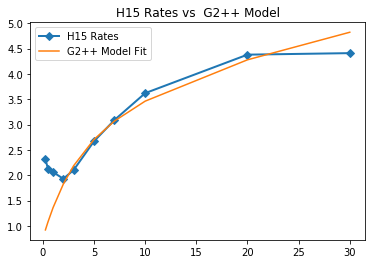

In [12]:
plt.plot(tenors,R_act,linewidth=2,label="H15 Rates",marker="D")
plt.plot(tenors,R_g2,label="G2++ Model Fit")
plt.legend()
plt.title("H15 Rates vs  G2++ Model")

### Curve sensitivity to parameters r1 and r2

The curves $D_1(t,T)$ and $D_2(t,T)$ control how a change in the factor affects the shape of the rate curve.

A large $\lambda$ parameter implies that only the from of the curve changes. A small $\lambda$ implies that a change in the factor $r$ will trigger a more or less parallel shift in the curve.

This captures the observe dynamics of the yield curve where the front (short) tenors are move volatile that the long tenors.

Text(0.5,1,'Curve sensitivity to factor changes')

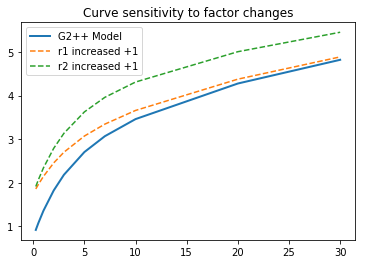

In [13]:
r1=r[:]
r1[0]+=1
R_dr1=yc.R(tenors,r1)
r2=r[:]
r2[1]+=1
R_dr2=yc.R(tenors,r2)
plt.plot(tenors,R_g2,label="G2++ Model",linewidth=2)
plt.plot(tenors,R_dr1,label="r1 increased +1",linestyle="dashed")
plt.plot(tenors,R_dr2,label="r2 increased +1",linestyle="dashed")
plt.legend()
plt.title("Curve sensitivity to factor changes")

## A model for the Treasury Curve (at a fixed date)

As a first step, we would like to build a model on how rates depend on tenor, for a fixed date. 

1. The functional form or yield curve $R(T)$ will be based on the G2++ model described above.
2. We will **train** the model  with the observations for the yields for tenors 3M, 6M, $1,\dots,10Y,20Y$ (excluding the 30Y treasury rate).

2. The $r_1$ and $r_2$ factors of the  G2++ model (assuming $\lambda_1$,$\sigma_1$, etc are known) will play the role of our model paremeters $\theta$.
3. We can then use the 30Y rate as an out of sample measure of the performance of our model.

#### Mathematical Details:
The observations of the treasury rates on a particular day are somewhat noisy, so they never fall exacty *on the theoretical curve*. We will therefore, assume noisy observations
$$
    R(T) = R_{G2++}(T) + \sigma(T) \epsilon
$$
where $\epsilon\sim N(0,1)$ and the variance $\sigma^2(T)=\frac{\sigma_0^2}{ T}$ decreases with $T$ to capture the fact that long dated rates are less volatile.

With this assumption finding $r_1$ and r_2 ammounts to solving a **weighted least squares problem**

$$
    E = \frac{1}{N_T} \sum_{t=1}^{N_T} w_t \left\{R(T_t) -R_{G2++}(T_t;r)\right\}^2
$$
    
where $T_t$ runs over the observed tenors in years $T_t=0.25, 0.5,1,2,3,5,7,10,20$. $N_T=9$ is the number of tenors used for fitting,  $r$ is the vector $(r_1,r_2)$, and the weights are $w_t=T_t \propto \frac{1}{\sigma^2(T)}$.

The function $R_{G2++}(T;r)$ is given by

\begin{align}
    R_{G2++}(T) &= R^0(T)+ H_1(T) r_1 + H_2(T) \\
    R^0(T) &= r_0 - \frac{1}{2}\frac{V(0,T)}{T}\\
    H_1(T) & =  \frac{D_1(0,T)}{T}\\
    H_2(T) & =  \frac{D_2(0,T)}{T}\\
\end{align}

The $N_T\times 2$ *feature matrix* $H$ is then given by
    
\begin{align}
    H_{t,1} &= H_1(T_t) \\
    H_{t,2} &= H_2(T_t) \\ 
\end{align}
definining rhe $N_T$ dimensional vector $\delta R$ as
$$
    \delta R_t = R(T_t) - R^0(T_t)
$$
and  the weight matrix  $W_t = diag(T_t)$ we have this is can be expressed in matrix form as
$$
    E =\frac{1}{N_T} (\delta R - H r)^T W (\delta R - H r)
$$
wher $R$ is the vector of all the H15 report rates $(R(3M), R(6M), R(1Y),\dots,R(20Y) )$, excluding the 30Y rate.

This problem has a solution
$$
    \hat{r} = (H^T W H)^{-1} (H^T W ) \delta R
$$
representing a yield curve best fitting the data
$$
    \hat{R}_{G2++}(T)= R_0(T) + H_1(T)\hat{r}_1 + H_2(T)\hat{r}_2
$$

    

<div class="alert alert-warning" > <b> Learning Problem 1</div>
Using the lenguage problem terminology we introduced in today's class, we have that we have the following 
1. $X$ represents the tenor $T$
2. $Y$ is  interest rate $R$ at point $T$ (at some fixed date that remains fixed during the problem). 
3. Our learning goal it to learn a function $y=f(x)$: the dependence of rates on tenor $R(T)$.
4. Our hypothesis space $h(x;\theta)$, is any posible linear combination
   $R(T; r)= R^0(T)+ H_{T,1} r_1 + H_{T,2} r_2$, where the parameters in $h(x;\theta)$ are $\theta=(r_1,r_2)$.
5. The error function $E$ is **weighted** mean square error.
5. The Learning algorighm is the exact solution to a linear regression problem $\hat{r}$.
6. The final hypothesis $\hat{h}$ is 
    $$ 
        \hat{R}_{G2++}(T) = R^0(T) + H_{1}(T) \hat{r}_1 + H_2(T) \hat{r}_2
    $$

#### Fit  $R_{G2++}(T)$ curve 

In [14]:
T=tenors[:-1]
T

array([ 0.25,  0.5 ,  1.  ,  2.  ,  3.  ,  5.  ,  7.  , 10.  , 20.  ])

In [15]:
yc.D1(T)

array([0.23500619, 0.44239843, 0.78693868, 1.26424112, 1.55373968,
       1.83583   , 1.93960523, 1.98652411, 1.9999092 ])

In [16]:
yc.D2(T)

array([ 0.24896122,  0.49585639,  0.98351699,  1.93479045,  2.85487746,
        4.60554825,  6.24331301,  8.50406068, 14.59748643])

In [17]:
R0=yc.R0(T)
R0

array([7.99999517, 7.99998201, 7.99993715, 7.99980209, 7.99963601,
       7.99926014, 7.99884106, 7.99813005, 7.99515509])

In [18]:
dR=(R_act[:-1]-R0).values
dR.shape

(9,)

In [19]:
W=np.diag(T)
W.shape

(9, 9)

In [20]:
WdR=np.dot(W,dR)
WdR.shape

(9,)

In [21]:
H=np.c_[yc.D1(T)/T,yc.D2(T)/T]
H.shape

(9, 2)

In [22]:
N=np.dot(H.T,np.dot(W,H))
N.shape

(2, 2)

In [23]:
r=np.linalg.solve(N,np.dot(H.T,WdR))
r

array([-2.12212832, -4.74241814])

In [24]:
R_g2=yc.R(tenors,r)
R_g2

array([1.28242913, 1.41921289, 1.6657035 , 2.07056849, 2.38755014,
       2.85179966, 3.18105648, 3.54358298, 4.32158267, 4.85246071])

Text(0,0.5,'Yield')

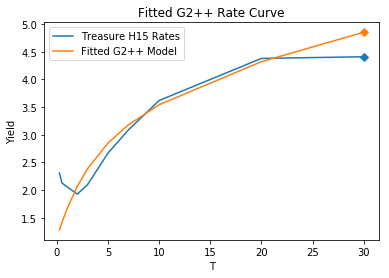

In [25]:
l=plt.plot(tenors,R_act,label="Treasure H15 Rates")
print(l)
plt.plot(tenors[-1],R_act[-1],"D",color=l[0].get_color())
l2=plt.plot(tenors,R_g2,label="Fitted G2++ Model")
plt.plot(tenors[-1],R_g2[-1],"D",color=l2[0].get_color())
plt.legend()
plt.title("Fitted G2++ Rate Curve")
plt.xlabel("T")
plt.ylabel("Yield")

#### Collecting curve fitting formulas into a function.

In [26]:
# here yc is the yield curve model (constains all the lambda, sigma, etc parameters)
def fit_curve(yc,T,R):
    R0=yc.R0(T)
    W=np.diag(T)
    dR=(R-R0)
    WdR=np.dot(W,dR)
    H=np.c_[yc.D1(T)/T,yc.D2(T)/T]
    N=np.dot(H.T,np.dot(W,H))
    r=np.linalg.solve(N,np.dot(H.T,WdR))
    return r

Let's observe fits for a few dates'

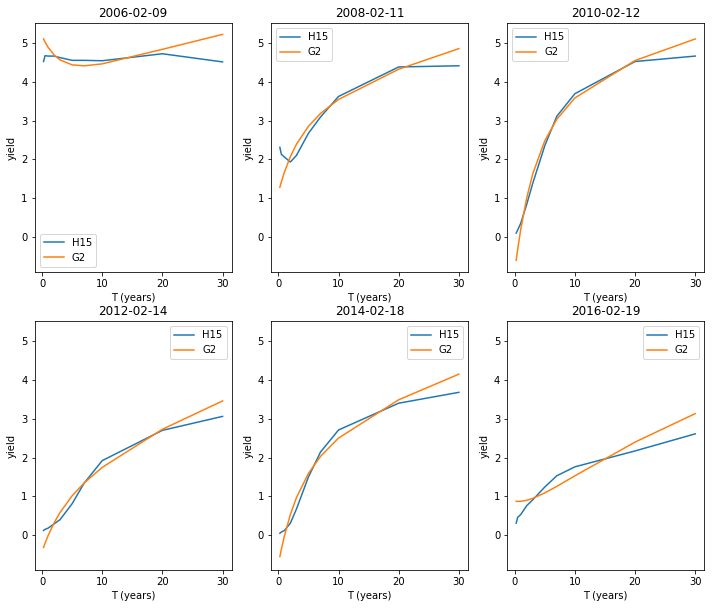

In [27]:

delta=251*2
plt.figure(figsize=(12,32))
ax1 = plt.subplot(2,3,1)
for i in range(6):
    R=H15.iloc[delta*i]
    r=fit_curve(yc,tenors[:-1],R[:-1])
    R_g2=yc.R(tenors,r)
    plt.subplot(6, 3, i+1,sharex=ax1,sharey=ax1)
    plt.ylabel("yield")
    plt.xlabel("T (years)")
    date1=H15.index[delta*i].date()
    plt.title(date1)
    plt.plot(tenors,R,label="H15")
    plt.plot(tenors,R_g2,label="G2")
    plt.legend()

We fit the curve up to 20 year ok, but our prediction of the 30Y rate does not look very good.

## Prediction of 30Y Rate Levels

### Model Hyper Parameters

So far we have taken the **hyper-parameters**
$$
    \theta = (r_0,\lambda_1,\sigma_1,\lambda_2,\sigma_2,\rho)
$$
as given.

Now we will now select them by comparing the 30 year rate prediction of each date to its actual observation for all dates.

We will assume the following model
$$
    R(30)_t = R_{G2++}(30;\theta)_t + \nu_t
$$
where $i=t,\dots, N$ runs through all dates in our training sample, $R_{G2++}(T)_t$ is the rate curve fitted to 
the 3M,6M,$\dots$,20Y tenors in the previous step, for  each one of the dates $t$, and $\nu_t$ is some gaussian noise term.

We are assuming that the error $\nu$ are independent for different dates
$$
    \mathbb{E}(\nu_t \nu_{t'}) = 0 \text{ if } t\ne t'
$$

Our error function is then
$$
    E = \frac{1}{N} \left\{ R(30)_t - R_{G2++}(30;\theta)_t \right\}^2
$$

Because the dependence of $R_{G2++}(T)$ on $\theta$ is non-linear, this is a **Non-Linear Least Squares** problem
that must be solve numerically.



<div class="alert alert-warning" > <b> Learning Problem 2 </div>

Using the lenguage problem terminology we introduced in today's class, we have that we have the following 

1. $X$ represents the yields $R(T)$ for tenors $T=0.25,\dots,20$, observed as of each date.
2. $Y$ is  yield $R(30)$ at point $T=30$ years. 
3. Our learning goal it to learn a function $y=f(x)$: the dependence of the 30 year yield $R(30)$ on the other points in the yield curve  $(R(0.25),R(0.5),\dots R(20))$.
4. Our hypothesis space $h(x;\theta)$, is any posible linear combination or the observed rates
   $R(30; \theta)= R^0(30;\theta)+ \beta^T(\theta)R$, where the parameters are $\theta=(r_0,\lambda_1,\sigma_1,\lambda_2,\sigma_2,\rho)$.
6. The bias $R^0(30; \theta)$ matrix and loadings  $\beta(\theta)$ depend non-linearly of $\theta$. 
6. The error function $E$ is mean square error.
5. The Learning algorighm will be a numerical non-linear least squares regression solver.
6. The final hypothesis $\hat{h}$ is 
    $$ 
        \hat{R}_{G2++}(30) = R^0(30;\hat{\theta}) + \beta^T(\hat{\theta})R
    $$
    where $\hat{\theta}$ is  the optimal solution to the non-linear least squares optimization problem.

#### Training and Test Set ####

In [28]:
test_period=date(2016,12,31)

In [29]:
H15_train=H15[:test_period]
H15_test=H15[test_period:]
train_dates=H15_train.index
test_dates=H15_test.index
len(H15),len(H15_train),len(H15_test)

(3149, 2728, 421)

### The 30Y Treasury Prediction Error Function


In [30]:
def errors_30Y(r0,lambda1,lambda2,sig1,sig2,rho,H15,tenors):
    yc=G2_RateCurve(r0,lambda1,lambda2,sig1,sig2,rho)
    N=len(H15)
    errors=np.zeros((N))
    for t in range(N):
        R=H15.iloc[t]
        r=fit_curve(yc,tenors[:-1],R[:-1])
        R_30=R[-1]
        R_30_g2=yc.R(tenors[-1],r)
        errors[t]=(R_30-R_30_g2)
    return errors

In [31]:
errors=errors_30Y(r0,lambda1,lambda2,sig1,sig2,rho,H15_train,tenors)
print("Standard Deviation of Mean Squared Error:\n\t",np.sqrt(np.mean(errors**2)))

Standard Deviation of Mean Squared Error:
	 0.5408950298823115


A 54bps error for the 30 year bond is pretty bad. We still need to optimize the parameters.


#### Speeding up the Model Error Calculation

In the implementation of the prediction error above, we:
1. loop over each observation date
2. fit a rate curve by calling `fit_curve`
3. Extrapolate the 30Y point based on the fitted parametes
4. Compute the error

Although conceptually, this is the clearest way to compute the error, it is **very inefficient** in python.

Taking advantage of the fact that the curve model is **linear** in the input rates, we can speed up the solution
significantly.


We showed before that for each date
$$
 \hat{r} = (H^T W H)^{-1} (W H^T) \delta R
$$
where $r$ is a 2 dimensional factir vector and $\delta R$ is an $N_T=9$ dimensional vector.

Therefore, the matrix P defined by
$$
    P = (H^T W H)^{-1} (W H^T)
$$
is a $2\times 9$ dimensional  matrix. 


We define $\hat{r}_{i,d}$ as the $N\times 2$ matrix of factors for each date $i=1,\dots N$ and
$$ 
   \delta R_{i,t}=R(T_t)_{i} - R^0(T_t)_{i}
$$ 

for $t=1,\dots,N_T$ and  the tenors $T_t=0.25,0.5,\dots20$.
 
 We then have
 $$
     \hat{r}_{i,d} = \sum_t  \delta R_{i,t}P_{d,t}
 $$
 or in matrix notation 
 $$ 
  \hat{r} = \delta R\, P^T
 $$
 where now $\hat{r}$ is a matrix referring to the factors for all times simultaneously.
 
 This allow us to fit the yield curve models for all dates simultaneusly using a **single matrix multiplication**.
 
 The extrapolation to the 30 year rate can again, be expressed as a single linear operation for all observations
 $$
 R_{G2++}(30)_i = R^0(30) + \sum_d H(30)_d \hat{r}_{i,d}
 $$
 where $H$ is as we defined before, therefore, the extrapolation error can be expressed as a single operation as
 
 $$
 \Delta R(30)_i = R(30)_{i} - R^0(30) - \sum_d \sum_t H(30)_d P_{d,t} R_{i,t} 
$$
or, in matrix form
$$
   \Delta R(30) = R(30)-R^0(30) - (R P^T) H(30) 
$$
we implement this  below

In [32]:
def errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,H15,tenors):
    yc=G2_RateCurve(r0,lambda1,lambda2,sig1,sig2,rho)
    dR=H15-yc.R0(tenors)
    T=tenors[:-1]
    x=dR[:,:-1]
    W=np.diag(T)
    H=np.c_[yc.D1(T)/T,yc.D2(T)/T]
    N=np.dot(H.T,np.dot(W,H))
    Ninv=np.linalg.inv(N)
    P=np.dot(Ninv,np.dot(H.T,W))
    T30=tenors[-1]
    H30=np.array([yc.D1(T30)/T30,yc.D2(T30)/T30])
    r=np.dot(x,P.T)
    E=dR[:,-1]-np.dot(r,H30)
    return E
    

returns are identical

In [33]:
errors2=errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,H15_train.values,tenors)
print("Standard Deviation of Mean Squared Errror:\n\t",np.sqrt(np.mean(errors2**2)))

Standard Deviation of Mean Squared Errror:
	 0.5408950298823118


In [34]:
%time err=errors_30Y(r0,lambda1,lambda2,sig1,sig2,rho,H15,tenors)

CPU times: user 2.32 s, sys: 7.71 ms, total: 2.33 s
Wall time: 2.14 s


In [35]:
%time err2=errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,H15.values,tenors)

CPU times: user 0 ns, sys: 1.21 ms, total: 1.21 ms
Wall time: 1.22 ms


The second method is  **2000 times** faster,

Without this optimization, optimizing over hyper-parameters $\theta=(\lambda_1,\sigma_1,\dots)$ would take nearly an  hour.

### Numerical Optimization

We do not have easy access to the gradient of $R_{G2++}(T)$ relative to the parameters $theta$ so we must resort to a least square method
that does not requires derivatives.
1. We use the **Levenberg-Marquard** method as implemented in numpy.
2. We resort to a change of variables to ensure that constrains of $\theta$ are satisfied.

In [36]:
def x_to_params(x):
    r0=x[0]
    lambda1=np.exp(-x[1]) # [ 0, infinity]
    lambda2=np.exp(-x[2]) # [0,  infinity]
    sig1=np.abs(x[3]) # sigma must be positive, but it mostly just appears as sigma^2
    sig2=np.abs(x[4])
    rho=np.tanh(x[5]) # [-1,1]
    return r0,lambda1,lambda2,sig1,sig2,rho

In [37]:
def params_to_x(r0,lambda1,lambda2,sig1,sig2,rho):
    x=np.empty((6,))
    x[0]=r0
    x[1]=-np.log(lambda1)
    x[2]=-np.log(lambda2)
    x[3]=sig1
    x[4]=sig2
    x[5]=np.arctanh(rho)
    return x

In [38]:
def objective_function(x,rates,tenors):
    r0,lambda1,lambda2,sig1,sig2,rho=x_to_params(x)
    return errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,rates.values,tenors)

In [39]:
r0,lambda1,lambda2,sig1,sig2,rho

(8, 0.5, 0.03333333333333333, 0.02, 0.01, 0)

In [40]:
x0=params_to_x(r0,lambda1,lambda2,sig1,sig2,rho)
x0

array([8.        , 0.69314718, 3.40119738, 0.02      , 0.01      ,
       0.        ])

In [41]:
x_to_params(x0)

(8.0, 0.5, 0.03333333333333333, 0.02, 0.01, 0.0)

In [42]:
errors=objective_function(x0,H15_train,tenors)
errors.shape

(2728,)

#### Optimal parameters

In [43]:
fit=scipy.optimize.least_squares(objective_function,x0,method="lm",args=(H15_train,tenors))
fit

 active_mask: array([0, 0, 0, 0, 0, 0])
        cost: 22.360421441583618
         fun: array([-0.10069338, -0.09749177, -0.08426279, ..., -0.08179869,
       -0.08362729, -0.07068674])
        grad: array([-0.00010857, -0.00012869,  0.00059695, -0.00015257,  0.00704637,
        0.00056406])
         jac: array([[-0.15471799,  0.0192123 ,  0.7725144 , -0.21742215, 10.04155343,
         0.80382552],
       [-0.15471799,  0.0173556 ,  0.76702607, -0.21742215, 10.04155343,
         0.80382552],
       [-0.15471799,  0.015511  ,  0.76689071, -0.21742215, 10.04155343,
         0.80382552],
       ...,
       [-0.15471799, -0.03585962,  0.96996872, -0.21742215, 10.04155343,
         0.80382552],
       [-0.15471799, -0.04187811,  0.96976904, -0.21742215, 10.04155343,
         0.80382552],
       [-0.15471799, -0.04061838,  0.974342  , -0.21742215, 10.04155343,
         0.80382552]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 88
        njev: None
  optimality: 0.

In [44]:
r0,lambda1,lambda2,sig1,sig2,rho=x_to_params(fit.x)
r0,lambda1,lambda2,sig1,sig2,rho

(7.985645172656848,
 0.3287044775118683,
 0.03402111237187884,
 0.020290820256976125,
 0.11265413878153019,
 -0.006372684744749233)

### 30Y Treasure Level Mean Squared In Sample Error

In [45]:
yc=G2_RateCurve(r0,lambda1,lambda2,sig1,sig2,rho)

In [46]:
train_errors=errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,H15_train.values,tenors)
print("Standard Deviation 30Y Yield",H15_train["30Y"].std())
print("Standard Error Prediction",np.sqrt(np.mean(train_errors**2)))
print("R2",1-np.mean(train_errors**2)/H15_train["30Y"].var())

Standard Deviation 30Y Yield 0.833857908538586
Standard Error Prediction 0.12803620914257377
R2 0.9764233818184898


We have reduded the, in sample error significantly, 97.6% $R^2$.

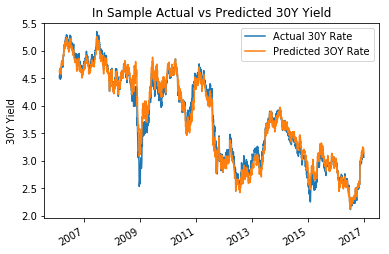

In [47]:
plt.plot(train_dates,H15_train["30Y"],label="Actual 30Y Rate")
plt.plot(train_dates,H15_train["30Y"]-train_errors,label="Predicted 3OY Rate")
plt.legend()
plt.title("In Sample Actual vs Predicted 30Y Yield")
plt.ylabel("Date")
plt.ylabel("30Y Yield")
ax=plt.gca()
fig=plt.gcf()
ax.xaxis_date()
fig.autofmt_xdate()

The curve fits for each particular date also look much better, and extrapolate to the 30Y much better.

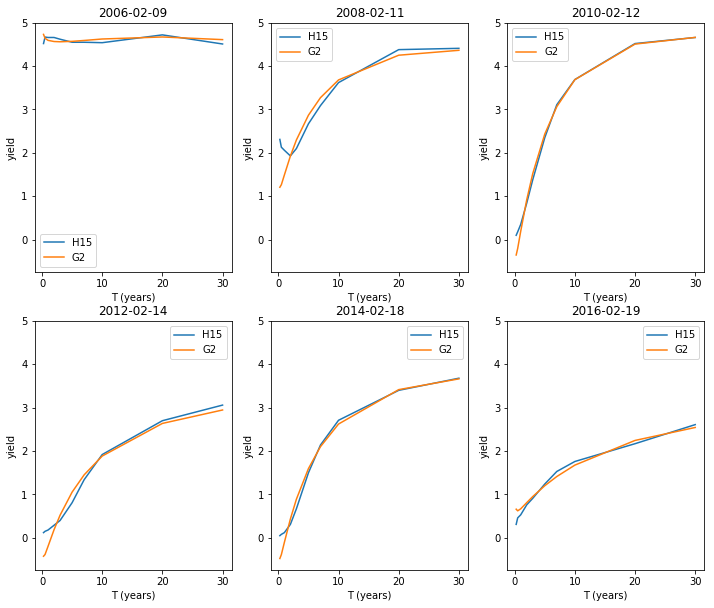

In [48]:
delta=251*2
plt.figure(figsize=(12,32))
ax1 = plt.subplot(2,3,1)
for i in range(6):
    R=H15_train.iloc[delta*i]
    r=fit_curve(yc,tenors[:-1],R[:-1])
    R_g2=yc.R(tenors,r)
    plt.subplot(6, 3, i+1,sharex=ax1,sharey=ax1)
    plt.ylabel("yield")
    plt.xlabel("T (years)")
    date=H15_train.index[delta*i].date()
    plt.title(date)
    plt.plot(tenors,R,label="H15")
    plt.plot(tenors,R_g2,label="G2")
    plt.legend()

The error plots, however, still look **auto-correlated**.

Errors from different samples are not independent from each other (as we assumed). This usually means trouble for **generalization**.

Text(0.5,0,'date')

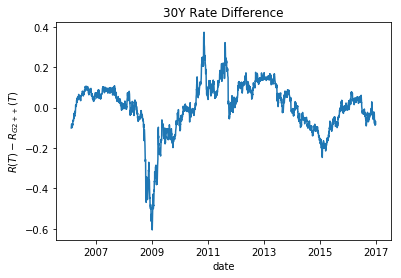

In [49]:
plt.plot(train_dates,train_errors)
plt.title("Training Sample Residual")
plt.title("Test Date")
plt.title("30Y Rate Difference")
plt.ylabel("$R(T)-R_{G2++}(T)$")
plt.xlabel("date")

#### Auto Correlation Function

The auto-correlation graph shows very significant auto-correlation between different samples
$$
   \gamma(h)=\frac{ E( e_t e_{t+h} ) }{E(e_t e_t)}
$$
where
$$
    e_t = R(T)_t - R_{G2++}(T)_t
$$
that should be zero for $h\ne0$.

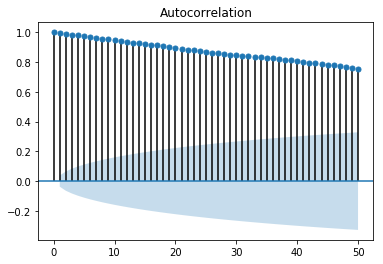

In [50]:
 a=statsmodels.graphics.tsaplots.plot_acf(train_errors,lags=50)

### Test Error on Levels

In [51]:
test_errors=errors_30Y_fast(r0,lambda1,lambda2,sig1,sig2,rho,H15_test.values,tenors)
print("Standard Deviation 30Y Yield",H15_test["30Y"].std())
print("Error Prediction squared",np.sqrt(np.mean(test_errors**2)))
print("R2",1-np.mean(train_errors**2)/H15_test["30Y"].var())

Standard Deviation 30Y Yield 0.13279348351352924
Error Prediction squared 0.1261458602887342
R2 0.07036581170642442


We only achieve explain  7% of the variation on $R^2$, this is because the average error is non-zero. 
There is **bias** on the test sample predictions.

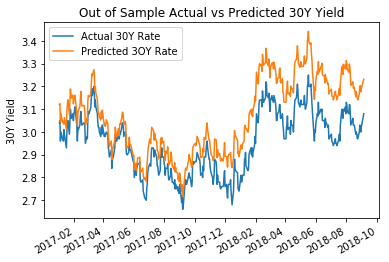

In [52]:
plt.plot(test_dates,H15_test["30Y"],label="Actual 30Y Rate")
plt.plot(test_dates,H15_test["30Y"]-test_errors,label="Predicted 3OY Rate")
plt.legend()
plt.title("Out of Sample Actual vs Predicted 30Y Yield")
plt.ylabel("Date")
plt.ylabel("30Y Yield")
ax=plt.gca()
fig=plt.gcf()
ax.xaxis_date()
fig.autofmt_xdate()

Average error does not look too large

Text(0.5,1,'30Y Rate Difference')

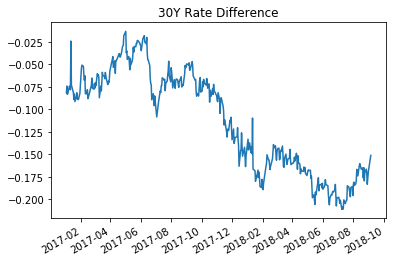

In [53]:
test_dates=H15_test.index
fig, ax = plt.subplots()
plt.plot(test_dates,test_errors)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.title("Out of Sample Residual")
plt.title("Test Date")
plt.title("30Y Rate Difference")

But the residuals are very **biased**, the expected value of the error is not zero.

We can see that the G2 model curve always overerstimates the 30Y rate.

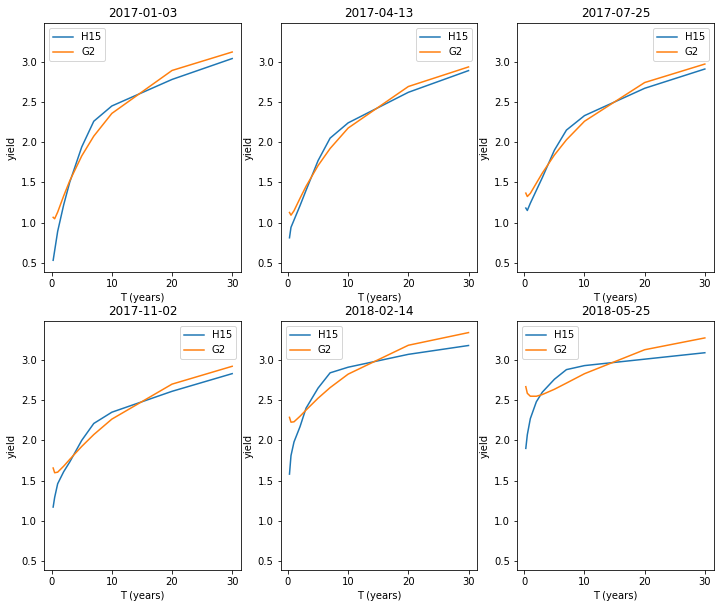

In [54]:
delta=70
plt.figure(figsize=(12,32))
ax1 = plt.subplot(2,3,1)
for i in range(6):
    R=H15_test.iloc[delta*i]
    r=fit_curve(yc,tenors[:-1],R[:-1])
    R_g2=yc.R(tenors,r)
    plt.subplot(6, 3, i+1,sharex=ax1,sharey=ax1)
    plt.ylabel("yield")
    plt.xlabel("T (years)")
    date=H15_test.index[delta*i].date()
    plt.title(date)
    plt.plot(tenors,R,label="H15")
    plt.plot(tenors,R_g2,label="G2")
    plt.legend()

## Prediction of 30Y Rate Changes

A standard trick when levels of a variable show high auto-correlation is to perform regression
on **changes of the variable**

Because the $R_{G2=+}(T)$ model is **linear on rates** we can first compute rate changes and them optimize.

In [55]:
dH=(H15.shift()-H15).dropna()
dH.head()

,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
DATE,,,,,,,,,,
2006-02-10,-0.01,-0.03,-0.04,-0.03,-0.05,-0.04,-0.04,-0.05,-0.04,-0.04
2006-02-13,-0.02,-0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.00,-0.01
2006-02-14,0.00,-0.01,-0.01,-0.01,-0.02,-0.03,-0.03,-0.04,-0.04,-0.04
2006-02-15,0.00,0.02,0.01,-0.02,0.00,0.01,0.01,0.01,0.02,0.02
2006-02-16,0.00,0.01,0.01,0.02,0.01,0.01,0.01,0.02,0.01,0.01


#### Separate Changes into test and train period

In [56]:
dH_train=dH[:test_period]
dH_test=dH[test_period:]
dtrain_dates=dH_train.index
dtest_dates=dH_test.index
len(dH),len(dH_train),len(dH_test)

(3148, 2727, 421)

#### Optimize model on changes

In [57]:
fit=scipy.optimize.least_squares(objective_function,x0,method="lm",args=(dH_train,tenors))
fit

 active_mask: array([0, 0, 0, 0, 0, 0])
        cost: 0.17534007152516995
         fun: array([-0.00347377, -0.01144281, -0.00088135, ..., -0.00092497,
        0.00720403, -0.01228636])
        grad: array([ 2.11391074e-05, -1.01518447e-04, -3.17911528e-04, -7.31709175e-04,
       -1.31419081e-03, -7.78012446e-04])
         jac: array([[-0.1494973 ,  0.69519243,  2.28028047,  5.17469919,  9.29404554,
         5.50215734],
       [-0.1494973 ,  0.69336179,  2.27713691,  5.17469919,  9.29404554,
         5.50215734],
       [-0.1494973 ,  0.69794527,  2.28233013,  5.17469919,  9.29404554,
         5.50215734],
       ...,
       [-0.1494973 ,  0.68557509,  2.26922206,  5.17469919,  9.29404554,
         5.50215734],
       [-0.1494973 ,  0.69609375,  2.27887933,  5.17469919,  9.29404554,
         5.50215734],
       [-0.1494973 ,  0.68928941,  2.27277636,  5.17469919,  9.29404554,
         5.50215734]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 371
        n

In [58]:
r0,lambda1,lambda2,sig1,sig2,rho=x_to_params(fit.x)
r0,lambda1,lambda2,sig1,sig2,rho

(7.987390300065242,
 0.10186979098727621,
 0.06609117826298322,
 0.040080283613088054,
 0.23463600214570104,
 0.03248722510028584)

#### In Sample Error

Model explains 96% of variance of 30Y rate in sample (in the training set)

In [59]:
dtrain_errors=errors_30Y(r0,lambda1,lambda2,sig1,sig2,rho,dH_train,tenors)
err_val=np.mean(dtrain_errors**2)
drate_val=np.mean(dH_train["30Y"]**2)
print("Sdt Error 30Y Rate",np.sqrt(drate_val))
print("Std Error 30Y Residual",np.sqrt(err_val))
print("In Sample R2",1-err_val/drate_val)

Sdt Error 30Y Rate 0.0566828424463353
Std Error 30Y Residual 0.01133999905980282
In Sample R2 0.9599757874555904


Errors are now clearly uncorrelated.

We see a bit of **clustering** of variante, may be we discuss this some other time.


Text(0.5,1,'30Y Rate Difference')

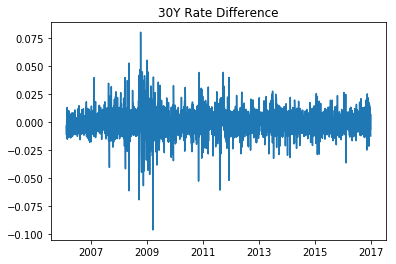

In [60]:
plt.plot(dtrain_dates,dtrain_errors)
plt.title("Training Sample Residual")
plt.title("Test Date")
plt.title("30Y Rate Difference")

Auto correlation function is know constistend with independence of residuals

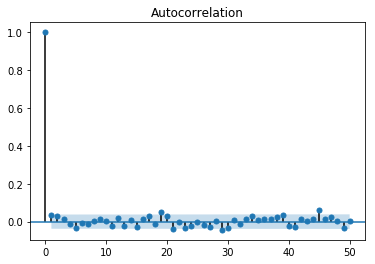

In [61]:
dtrain_errors=train_errors[:-1]-train_errors[1:]
a=statsmodels.graphics.tsaplots.plot_acf(dtrain_errors,lags=50)

#### Test sample error

Out of sample we still explain 94% of variance

In [62]:
dtest_errors=errors_30Y(r0,lambda1,lambda2,sig1,sig2,rho,dH_test,tenors)
err_test=np.mean(dtest_errors**2)
drate_test=np.mean(dH_test["30Y"]**2)
np.sqrt(err_test),np.sqrt(drate_test),1-err_test/drate_test

(0.008538758551476637, 0.03403226078806391, 0.9370482416124387)

### Simplification of G2 model for Changes on Rates

Note that, in the G2++ model, the rate curve shape has form
$$
    R_{G2++}(T)_t = R^0(T;r_0,\lambda_1,\lambda_2,\sigma_1,\sigma_2,\rho)+ \frac{D(T;\lambda_1)}{T}r_{t,2} + \frac{D(T;\lambda_2)}{T}r_{t,2}
$$
so that the change

$$
    \Delta R_{G2++}(T)_t = 
       R_{G2++}(T)_{t+1}-R_{G2++}(T)_{t}
       =  \frac{D(T;\lambda_1)}{T}\Delta r_{t,2} + \frac{D(T;\lambda_2)}{T}\Delta r_{t,2}
$$
with
$$
    \Delta r_{t,d} = r_{t+1,d}-r_{t,d}
$$
so that, for a model on changes parameters $r_0,\sigma_1,\sigma_2$ and $\rho$ do not appear on the model and we only
need to fit on $\lambda_1$ and $\lambda_2$

Therefore, the model for prediction 30Y rate  changes is simplified significantly:

In [63]:
class G2_FactorModel:
    def __init__(self,lambda1,lambda2):
        self.lambda1=lambda1
        self.lambda2=lambda2
    def D1(self,t):
        return (1-np.exp(-self.lambda1*t))/self.lambda1
    def D2(self,t):
        return (1-np.exp(-self.lambda2*t))/self.lambda2
    def H(self,t,r):
        return self.D1(t)/t*r[0]+self.D2(t)/t*r[1]

In [64]:
def errors_30Y_factors(lambda1,lambda2,dRates,tenors):
    yc=G2_FactorModel(lambda1,lambda2)
    T=tenors[:-1]
    x=dRates[:,:-1]
    W=np.diag(T)
    H=np.c_[yc.D1(T)/T,yc.D2(T)/T]
    N=np.dot(H.T,np.dot(W,H))
    Ninv=np.linalg.inv(N)
    P=np.dot(Ninv,np.dot(H.T,W))
    T30=tenors[-1]
    H30=np.array([yc.D1(T30)/T30,yc.D2(T30)/T30])
    r=np.dot(x,P.T)
    E=dRates[:,-1]-np.dot(r,H30)
    return E
    

In [65]:
def x_to_factors(x):
    r0=x[0]
    lambda1=np.exp(-x[0]) # [ 0, infinity]
    lambda2=np.exp(-x[1]) # [0,  infinity]
    return lambda1,lambda2

In [66]:
def factors_to_x(lambda1,lambda2):
    x=np.empty((2,))
    x[0]=-np.log(lambda1)
    x[1]=-np.log(lambda2)
    return x

In [67]:
def factor_function(x,rates,tenors):
    lambda1,lambda2=x_to_factors(x)
    return errors_30Y_factors(lambda1,lambda2,rates.values,tenors)

In [68]:
lambda1=0.01
lambda2=0.5
x0=factors_to_x(lambda1,lambda2)
x0

array([4.60517019, 0.69314718])

In [69]:
fit=scipy.optimize.least_squares(factor_function,x0,method="lm",args=(dH_train,tenors))
fit

 active_mask: array([0, 0])
        cost: 0.17534152257292196
         fun: array([-0.00344188, -0.01140961, -0.0008488 , ..., -0.00089156,
        0.00723816, -0.01225284])
        grad: array([7.51990880e-08, 8.36155072e-08])
         jac: array([[ 0.00427456,  0.00348812],
       [ 0.00113335,  0.00165411],
       [ 0.00632589,  0.00623957],
       ...,
       [-0.00678211, -0.00613375],
       [ 0.00287795,  0.0043839 ],
       [-0.00322709, -0.00241942]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 19
        njev: None
  optimality: 8.361550720044353e-08
      status: 2
     success: True
           x: array([2.71574041, 2.2850279 ])

In [70]:
lambda1,lambda2=x_to_factors(fit.x)
print(lambda1,lambda2)

0.06615595215831892 0.10177122253315299


Results are equivalent to fitting the full model.